# TalkingData Model Development and Training

## Model Development
After EDA and Feature Engineering, now our data is in good shape for us to progress further. The next stage is to develop the model and follow by training the model by fitting the data.  

### Cat2Vec Training - To train the vocab vector using full train data
For Cat2Vec encoding, first we have to collect the vocab and trains its vector encoding usng gensim Word2Vec package. The training is done with full train data.

In [2]:
import random 
from gensim.models import Word2Vec
import os

os.environ['PYTHONHASHSEED'] = '0'

random.seed(4)

categories = ['ip','app','device','os','channel']

def preProcessRow(line):
    # extract, prepend category name, shuffle
    extractedCategories = line.split(',')[0:5]
    
    for i,item in enumerate(categories):
        extractedCategories[i] = "%s %s" % (categories[i], extractedCategories[i])
        
    return extractedCategories    
    
# Use iterator to avoid reading the full train data into memory
class DataRows(object):
    def __init__(self, filename):
        self.filename = filename
    
    def __iter__(self):        
        with open(self.filename) as f:
            f.readline() # skip header
            for line in f:
                catCols = preProcessRow(line) 
                random.shuffle(catCols)
                yield catCols 


In [2]:
#training
sentences = DataRows('./data/talkingdata_train_raw.csv') # a memory-friendly iterator
model = Word2Vec(sentences, size=5, window=7, min_count=5, workers=6)   

In [3]:
model.save("./cat2vec.model")
print('Cat2Vec Training Done!')

Cat2Vec Training Done!


In [10]:
print(len(model.wv.vocab))

185749


In [3]:
#try to load the save model
model = Word2Vec.load("./cat2vec.model")

### Create Pipeline
Then we will re-implement some of our transformation logic as Scikit-Learn Transformer so that they can be assembled into SciKit Learn Pipeline.

In [6]:
%%writefile CustomTransformer.py 

# Cat2Vec - good to have to avoid data leak, but problem is slow in training,
# so it is not implemented as transformer, refer to another notebook for Cat2Vec custom transformer
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
import copy
import numpy as np 
import pandas as pd 
from random import shuffle

def datetime_transform(x):
    #import pdb
    #pdb.set_trace()
    for c in x.columns.values:
        x.loc[:, c] = pd.to_datetime(x[c])
        x.loc[:, c] = x[c].dt.round('H').dt.hour
        x.loc[:, c+'_sin'] = np.sin(x[c]*(2.*np.pi/24))
        x.loc[:, c+'_cos'] = np.cos(x[c]*(2.*np.pi/24))
        x.drop([c], axis=1, inplace=True)
    return x.values     

def log_transform(x, shift=1):
    return np.log(x + shift)

Overwriting CustomTransformer.py


In [7]:
# convert time to nearest hour (use FunctionTransformer as it is stateless)
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from CustomTransformer import datetime_transform, log_transform
from sklearn.preprocessing import FunctionTransformer
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler

log_transform_cols = ['cumcount_by_ip_app_past_5min',
       'cumcount_by_ip_app_past_1hr_to_8hr',
       'cumcount_by_ip_app_os_past_5min',
       'cumcount_by_ip_app_os_past_5min_to_1hr',
       'cumcount_by_ip_app_os_past_1hr_to_8hr',
       'cumcount_by_ip_device_os_past_5min',
       'cumcount_by_ip_device_os_past_5min_to_1hr',
       'cumcount_by_ip_device_os_past_1hr_to_8hr',
       'cumcount_by_ip_device_os_app_channel_past_5min',
       'cumcount_by_ip_device_os_app_channel_past_5min_to_1hr',
       'cumcount_by_ip_device_os_app_channel_past_1hr_to_8hr',
       'cumcount_by_ip_past_5min',
       'cumcount_by_ip_past_5min_to_1hr',
       'cumcount_by_ip_past_1hr_to_8hr']

datetime_cols = ['click_time']

datetime_transformer = FunctionTransformer(datetime_transform, validate=False)
log_transformer = FunctionTransformer(log_transform, validate=False)
scaler = StandardScaler()

preprocess_cols = make_column_transformer(
   (datetime_transformer, datetime_cols),
   (log_transformer, log_transform_cols),
   remainder = 'passthrough' 
)

preprocess_all =  Pipeline([('preprocess', preprocess_cols), ('scaler', scaler)])



### Development and Local Training
Due to limited memory and processing resources, for development and local training we will just do a down sampling using BigQuery. As it is highly imbalanced dataset, records with attributed=1 are completely included but records with attributed=0 are down sampled randomly.  

In [8]:
import csv
import numpy as np

#replace the original categories with category vectors, we perform the conversion line by line, this approach 
#doesn't have memory constraint and it will work too for full train data  
vocab = set(model.wv.index2word)
n_cat2vec_feature = len(categories)
cat2vec_feature_size = 5

with open("./data/train_extra_sample.csv", "r") as f:
    with open("./data/train_extra_sample_catvec.csv",'w') as resultFile:
        wr = csv.writer(resultFile, lineterminator="\n")
        line = f.readline().rstrip('\n')
        wr.writerow(["cat_vec_%s"%i for i in range(25)]+line.split(',')[5:])
        for line in f:
            line = line.rstrip('\n')
            extractedCats = preProcessRow(line)
            extractedNumerics = line.split(',')[5:]  
            allCatVector = np.zeros((n_cat2vec_feature * cat2vec_feature_size,), dtype="float64")

            for index, catItem in enumerate(extractedCats):
                if catItem in vocab:
                    startIndex = index * cat2vec_feature_size
                    endIndex = (index + 1) * cat2vec_feature_size
                    allCatVector[startIndex : endIndex] = model[catItem]

            allCols = np.append(allCatVector, extractedNumerics)           
            wr.writerow(allCols)
            

/home/czehoul/machineLearningVenv/lib/python3.5/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [8]:
#read the result file after cat2vec conversion
train_df = pd.read_csv("./data/train_extra_sample_catvec.csv")
train_df.reset_index(drop=True, inplace=True)

In [9]:
from sklearn.model_selection import train_test_split
y = train_df.pop('is_attributed')
X_train, X_test, y_train, y_test = train_test_split(train_df, y, random_state=1)

In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205348 entries, 48816 to 170325
Data columns (total 45 columns):
cat_vec_0                                                205348 non-null float64
cat_vec_1                                                205348 non-null float64
cat_vec_2                                                205348 non-null float64
cat_vec_3                                                205348 non-null float64
cat_vec_4                                                205348 non-null float64
cat_vec_5                                                205348 non-null float64
cat_vec_6                                                205348 non-null float64
cat_vec_7                                                205348 non-null float64
cat_vec_8                                                205348 non-null float64
cat_vec_9                                                205348 non-null float64
cat_vec_10                                               205348 non-null fl

Then, we have to establish a Baseline or Baseline Model. It is not easy to establish a baseline model for this problem programmatically (without machine learning) as we can't easily define set of logic to classify the data. We can simply guess all records are not attributed as this is imbalanced data with majority of records are not attributed. If we do so, in term of ROC AUC score we will get 0.5. Therefore any model with ROC AUC score greater than 0.5 is consider better than random guess. We can also further develop a simple machine learning model with default parameter as our Baseline Model as below.        

In [37]:
#Baseline model
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
decision_tree_clf =  DecisionTreeClassifier()
pipeline = Pipeline([('all_preprocess', preprocess_all), ('clf', decision_tree_clf)])
pipeline.fit(X_train,y_train)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8788777619740002


Then we will develop a model using XGBoost. We will start with default hyperparameters, plot the learning curve and follows by tuning XGBoost hyperparameters to get optimum result. 

In [35]:
# A quick test to verify all are working fine
import xgboost as xgb
xgboost_clf =  xgb.XGBClassifier()
pipeline = Pipeline([('all_preprocess', preprocess_all), ('clf', xgboost_clf)])
pipeline.fit(X_train,y_train)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.9617822606438504


Lets trains the model and plot the learning curve.

In [41]:
from sklearn.model_selection import learning_curve
import xgboost as xgb

xgboost_clf =  xgb.XGBClassifier()
pipeline_clf = Pipeline([('all_preprocess', preprocess_all), ('clf', xgboost_clf)])

train_sizes, train_scores, test_scores = learning_curve(pipeline_clf, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='roc_auc',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 10 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

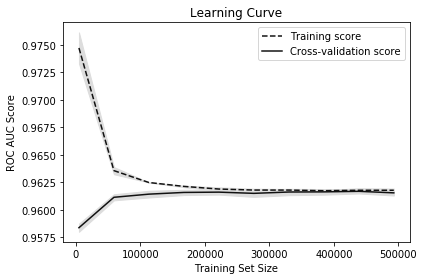

In [42]:
import matplotlib.pyplot as plt
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("ROC AUC Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

From the learning curve above, we probably have high bias/under fitting problem. We need more features and more complex model. In this case, we will try to tune XGBoost hyper parameter to allow the model to be more complicated. We will use Bayesian Optimization with Hyperopt package to tune XGBoost hyperparameters automatically.

In [80]:
#Prepare training log
import csv
import datetime


out_file = 'xgboost_trials.csv'

def write_log(row):
    file_connection = open(out_file, 'a')
    writer = csv.writer(file_connection)
   
    writer.writerow(row)
    file_connection.close()

In [83]:
write_log(['loss', 'params', 'iteration', 'train_time'])

In [94]:
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin
from hyperopt import Trials
from hyperopt import STATUS_OK
from sklearn.model_selection import cross_val_score


space = {
    "clf__max_depth":  hp.quniform('clf__max_depth', 3, 10, 1),    
    'clf__learning_rate': hp.loguniform('clf__learning_rate', np.log(0.01), np.log(0.2)),
    'clf__min_child_weight': hp.quniform('clf__min_child_weight', 1, 6, 1),    
    'clf__reg_alpha': hp.uniform('clf__reg_alpha', 0.0, 1.0),
    'clf__reg_lambda': hp.uniform('clf__reg_lambda', 0.0, 1.0),
    'clf__subsample': hp.uniform('clf__subsample', 0.5, 1.0),
    'clf__colsample_bytree': hp.uniform('clf__colsample_bytree', 0.5, 1.0)    
}

MAX_EVALS = 100
N_FOLDS = 7
iteration = 0

def objective(params, n_folds = N_FOLDS):
    """Objective function for XGBoost Hyperparameter Tuning"""
    global iteration 
    iteration += 1
    
    xgboost_clf =  xgb.XGBClassifier(n_estimators=200)
    
    pipeline_clf = Pipeline([('all_preprocess', preprocess_all), ('clf', xgboost_clf)])
    
    pipeline_clf.set_params(
        clf__max_depth=int(params.get('clf__max_depth')),
        clf__learning_rate=float(params.get('clf__learning_rate')),
        clf__min_child_weight=int(params.get('clf__min_child_weight')),
        clf__reg_alpha=float(params.get('clf__reg_alpha')),
        clf__reg_lambda=float(params.get('clf__reg_lambda')),
        clf__subsample=float(params.get('clf__subsample')),
        clf__colsample_bytree=float(params.get('clf__colsample_bytree'))
        )
    
    # Perform n_fold cross validation with hyperparameters
    # We should use early stopping, but unfortunately XGBoost SciKit learn wrapper cant support early stopping in CV  
       
    cv_scores = cross_val_score(pipeline_clf, X_train, y_train, cv=n_folds, scoring='roc_auc', n_jobs=-1)
  
    # Extract the best score
    best_score = cv_scores.mean()
    
    # Loss must be minimized
    loss = 1 - best_score
    
    write_log([loss, params, iteration, datetime.datetime.now()])
        
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

bayes_trials = Trials()

# Optimize
best_params = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 100/100 [47:25:22<00:00, 1285.81s/it, best loss: 0.02795185865304617]   


In [96]:
best_params

{'clf__colsample_bytree': 0.5141845347206645,
 'clf__learning_rate': 0.09161924835975353,
 'clf__max_depth': 10.0,
 'clf__min_child_weight': 4.0,
 'clf__reg_alpha': 0.4863462796562168,
 'clf__reg_lambda': 0.7185839745545605,
 'clf__subsample': 0.9601716018090558}

In [101]:
#Use the best parameters to fit the train set
xgboost_clf =  xgb.XGBClassifier(n_estimators=200, colsample_bytree=0.5141845347206645,
 learning_rate=0.09161924835975353,
 max_depth=10,
 min_child_weight=4,
 reg_alpha=0.4863462796562168,
 reg_lambda=0.7185839745545605,
 subsample=0.9601716018090558)    
pipeline_clf = Pipeline([('all_preprocess', preprocess_all), ('clf', xgboost_clf)])
pipeline_clf.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('all_preprocess', Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('functiontransformer-1', FunctionTransformer(accept_sparse=False, check_inverse=True,
  ...745545605,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9601716018090558))])

In [102]:
y_pred_prob = pipeline_clf.predict_proba(X_train)[:, 1]
print("Train Set Score = ", metrics.roc_auc_score(y_train, y_pred_prob))

Train Set Score =  0.9826101193607546


In [103]:
y_pred_prob = pipeline_clf.predict_proba(X_test)[:, 1]
print("Test Set Score = ", metrics.roc_auc_score(y_test, y_pred_prob))

Test Set Score =  0.9723152575990346


## Model Training - Production Scale

After feature engineering and transformation, the transformed full train data size is greater than 100 GB. To train this data set, we have to perform distributed training in Spark cluster. The code above has to be re-writtten in PySaprk and Spark ML. Due to limited resources and time, this is out of scope for this notebook. This is to be done in next notebook when time permits.  